In [1]:
### CELL 1: Setup and Imports ###

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, hamming_loss, accuracy_score
import os
import json
from typing import Tuple, List, Dict
import random
import warnings
from tqdm import tqdm
import time
warnings.filterwarnings('ignore')

# Check if running on Colab
try:
    import google.colab
    IN_COLAB = True
    print("🎉 Running on Google Colab!")
    # Mount Google Drive if needed
    # from google.colab import drive
    # drive.mount('/content/drive')
except:
    IN_COLAB = False
    print("Running locally")

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration - prioritize CUDA
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"🚀 Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("🍎 Using Apple Metal Performance Shaders")
else:
    device = torch.device('cpu')
    print("💻 Using CPU (Training will be slower)")


🎉 Running on Google Colab!
🚀 Using GPU: Tesla T4
   Memory: 15.83 GB


### CELL 2: Understanding Metrics - DETAILED EXPLANATION ###

📊 METRICS EXPLAINED:

1. **LOSS (0.6931)**:
   - Binary Cross-Entropy loss for multi-label classification
   - Starting at 0.693 is EXPECTED (it's -ln(0.5) = random guessing)
   - Good model should reach 0.1-0.3
   - My first running of the model gave loss that didn't decrease much = model didn't learn properly

2. **HAMMING LOSS (0.4833)**:
   - Fraction of wrong labels per sample
   - Example: If true=[1,0,1,0] and pred=[1,1,1,0], hamming=0.25 (1 wrong out of 4)
   - 0.4833 means ~48% of individual labels are wrong (BAD - random is 50%)

3. **EXACT MATCH (0.1267)**:
   - % of samples where ALL labels are correct
   - Very strict metric
   - My first running of the model gave 12.67% which is poor but expected with random data

4. **PRECISION (0.4800)**:
   - Of all positive predictions, how many were correct?
   - "When model says 'yes', how often is it right?"

5. **RECALL (0.2700)**:
   - Of all actual positives, how many were found?
   - "Of all true labels, how many did model find?"
   - My first running of the model gave 27% recall that is LOW - model missed most positive labels

6. **F1 SCORE (0.3289)**:
   - Harmonic mean of Precision and Recall
   - Balanced metric between the two
   - Good models achieve 0.7-0.9

7. **EPOCH**:
   - One complete pass through entire training dataset
   - More epochs = more learning opportunities
   - Need 30-100 epochs for good performance

8. **BATCH**:
   - Number of samples processed before updating weights
   - Batch 32 = process 32 images, then update
   - Larger batch = more stable but needs more memory

WHY MY LOSS WAS BAD IN THE FIRST RUN:
- Used synthetic random data (no patterns to learn!)
- Only 10 epochs (too little)
- Model might had been too simple
- Learning rate might had needed tuning

In [2]:
### CELL 3: Optimized Dataset with Real Patterns ###

class OptimizedMultiLabelDataset(Dataset):
    """
    Optimized dataset that creates learnable patterns instead of pure random noise
    """

    def __init__(self, num_samples: int = 1000, num_classes: int = 4,
                 mode: str = 'train', transform=None):
        self.num_samples = num_samples
        self.num_classes = num_classes
        self.mode = mode
        self.transform = transform

        # Create synthetic but LEARNABLE patterns
        # This creates images with actual patterns the model can learn
        np.random.seed(42 if mode == 'train' else 43 if mode == 'val' else 44)

        self.data = []
        self.labels = []

        for i in range(num_samples):
            # Create image with patterns based on class
            img = np.zeros((224, 224, 3), dtype=np.uint8)
            label = np.zeros(num_classes)

            # Add patterns for each class (so model can actually learn something!)
            # Class 0: Horizontal stripes
            if np.random.random() > 0.5:
                for y in range(0, 224, 20):
                    img[y:y+10, :, 0] = 255
                label[0] = 1

            # Class 1: Vertical stripes
            if np.random.random() > 0.5:
                for x in range(0, 224, 20):
                    img[:, x:x+10, 1] = 255
                label[1] = 1

            # Class 2: Diagonal pattern
            if np.random.random() > 0.5:
                for i in range(224):
                    img[i, i, 2] = 255
                    if i > 0:
                        img[i-1, i, 2] = 200
                    if i < 223:
                        img[i+1, i, 2] = 200
                label[2] = 1

            # Class 3: Circle pattern
            if np.random.random() > 0.5:
                center = (112, 112)
                radius = 50
                y, x = np.ogrid[:224, :224]
                mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2
                img[mask] = [255, 255, 0]
                label[3] = 1

            # Ensure at least one label is active
            if label.sum() == 0:
                label[np.random.randint(0, num_classes)] = 1

            # Add some noise for regularization
            noise = np.random.randn(224, 224, 3) * 20
            img = np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)

            self.data.append(img)
            self.labels.append(label)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img = Image.fromarray(self.data[idx])

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label


In [3]:
### CELL 4: Enhanced CNN Architecture ###

class EnhancedCNN(nn.Module):
    """
    Improved CNN with better architecture for learning
    """

    def __init__(self, num_classes: int = 4, dropout_rate: float = 0.3):
        super(EnhancedCNN, self).__init__()

        # Deeper architecture with residual connections
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks for better gradient flow
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Classification head with dropout
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

class ResidualBlock(nn.Module):
    """Residual block for better gradient flow"""

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [4]:
### CELL 5: Advanced Training Functions ###

def train_epoch_optimized(model, dataloader, criterion, optimizer, scaler, epoch, total_epochs):
    """Optimized training with mixed precision and progress bar"""
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Progress bar
    pbar = tqdm(dataloader, desc=f'Epoch {epoch}/{total_epochs}')

    for batch_idx, (images, labels) in enumerate(pbar):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Mixed precision training for faster computation
        if device.type == 'cuda':
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy for progress bar
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.numel()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'avg_loss': f'{total_loss/(batch_idx+1):.4f}',
            'acc': f'{correct_predictions/total_predictions:.2%}'
        })

    return total_loss / len(dataloader)

def validate_epoch_optimized(model, dataloader, criterion):
    """Optimized validation"""
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validating'):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            all_predictions.append(outputs)
            all_targets.append(labels)

    all_predictions = torch.cat(all_predictions)
    all_targets = torch.cat(all_targets)

    metrics = calculate_metrics(all_predictions, all_targets)
    avg_loss = total_loss / len(dataloader)

    return avg_loss, metrics

def calculate_metrics(predictions, targets, threshold=0.5):
    """Calculate comprehensive metrics"""
    preds = (torch.sigmoid(predictions) > threshold).cpu().numpy()
    targets = targets.cpu().numpy()

    h_loss = hamming_loss(targets, preds)
    exact_match = accuracy_score(targets, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        targets, preds, average='samples', zero_division=0
    )

    return {
        'hamming_loss': h_loss,
        'exact_match': exact_match,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [5]:
def train_model(config=None):
    """
    Main training function with optimizations
    """
    # Default configuration
    if config is None:
        config = {
            'num_classes': 4,
            'batch_size': 64 if device.type == 'cuda' else 32,
            'learning_rate': 0.001,
            'num_epochs': 50,  # Increased for better learning
            'weight_decay': 1e-4,  # L2 regularization
            'scheduler': 'cosine',  # Learning rate scheduling
            'dropout': 0.3,
            'num_samples': 2000  # More data
        }

    print("🚀 Optimized Training Configuration:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # Data augmentation - more aggressive for better generalization
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets with learnable patterns
    print("\n📊 Creating datasets with learnable patterns...")
    train_dataset = OptimizedMultiLabelDataset(
        num_samples=config['num_samples'],
        num_classes=config['num_classes'],
        mode='train',
        transform=train_transform
    )
    val_dataset = OptimizedMultiLabelDataset(
        num_samples=config['num_samples']//5,
        num_classes=config['num_classes'],
        mode='val',
        transform=val_transform
    )
    test_dataset = OptimizedMultiLabelDataset(
        num_samples=config['num_samples']//5,
        num_classes=config['num_classes'],
        mode='test',
        transform=val_transform
    )

    # DataLoaders with optimizations
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=2 if device.type == 'cuda' else 0,
        pin_memory=True if device.type == 'cuda' else False
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=2 if device.type == 'cuda' else 0,
        pin_memory=True if device.type == 'cuda' else False
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'],
        shuffle=False
    )

    print(f"✅ Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    # Initialize model
    model = EnhancedCNN(
        num_classes=config['num_classes'],
        dropout_rate=config['dropout']
    ).to(device)

    print(f"🧠 Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Loss function with class weights for imbalanced data
    criterion = nn.BCEWithLogitsLoss()

    # Optimizer with weight decay for regularization
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )

    # Learning rate scheduler for better convergence
    if config['scheduler'] == 'cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=config['num_epochs'])
    else:
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    # Mixed precision scaler for faster training
    scaler = GradScaler() if device.type == 'cuda' else None

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': [],
        'learning_rates': []
    }

    best_f1 = 0
    best_epoch = 0

    print("\n🎯 Starting Optimized Training...")
    print("="*50)

    start_time = time.time()

    for epoch in range(1, config['num_epochs'] + 1):
        # Training
        train_loss = train_epoch_optimized(
            model, train_loader, criterion, optimizer, scaler, epoch, config['num_epochs']
        )

        # Validation
        val_loss, val_metrics = validate_epoch_optimized(model, val_loader, criterion)

        # Update learning rate
        if config['scheduler'] == 'cosine':
            scheduler.step()
        else:
            scheduler.step(val_loss)

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_metrics['f1_score'])
        history['val_precision'].append(val_metrics['precision'])
        history['val_recall'].append(val_metrics['recall'])
        history['learning_rates'].append(optimizer.param_groups[0]['lr'])

        # Print epoch summary
        print(f"\n📈 Epoch {epoch}/{config['num_epochs']} Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"  Val F1: {val_metrics['f1_score']:.4f} | Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f}")
        print(f"  Hamming Loss: {val_metrics['hamming_loss']:.4f} | Exact Match: {val_metrics['exact_match']:.4f}")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model
        if val_metrics['f1_score'] > best_f1:
            best_f1 = val_metrics['f1_score']
            best_epoch = epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_f1': best_f1,
                'config': config
            }, 'best_model.pth')
            print(f"  💾 New best model saved! F1: {best_f1:.4f}")

        print("-"*50)

    training_time = time.time() - start_time
    print(f"\n✅ Training completed in {training_time:.2f} seconds")
    print(f"🏆 Best F1 Score: {best_f1:.4f} at epoch {best_epoch}")

    # Load best model for final evaluation
    checkpoint = torch.load('best_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Final test evaluation
    print("\n🎯 Final Test Evaluation (Best Model):")
    test_loss, test_metrics = validate_epoch_optimized(model, test_loader, criterion)
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test F1: {test_metrics['f1_score']:.4f}")
    print(f"  Test Precision: {test_metrics['precision']:.4f}")
    print(f"  Test Recall: {test_metrics['recall']:.4f}")
    print(f"  Test Hamming Loss: {test_metrics['hamming_loss']:.4f}")
    print(f"  Test Exact Match: {test_metrics['exact_match']:.4f}")

    # Plot results
    plot_training_history(history)

    return model, history, test_metrics, test_loader  # Added test_loader to return

In [6]:
### CELL 7: Visualization Functions ###

def plot_training_history(history):
    """Create comprehensive training plots"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle('Training History', fontsize=16)

    # Loss plot
    axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss Curves')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # F1 Score plot
    axes[0, 1].plot(history['val_f1'], label='Val F1', color='green', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].set_title('F1 Score Progress')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Precision/Recall plot
    axes[0, 2].plot(history['val_precision'], label='Precision', color='blue', linewidth=2)
    axes[0, 2].plot(history['val_recall'], label='Recall', color='red', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].set_title('Precision vs Recall')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Learning rate plot
    axes[1, 0].plot(history['learning_rates'], color='orange', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].grid(True, alpha=0.3)

    # Loss difference plot
    loss_diff = np.array(history['val_loss']) - np.array(history['train_loss'])
    axes[1, 1].plot(loss_diff, color='purple', linewidth=2)
    axes[1, 1].axhline(y=0, color='gray', linestyle='--')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Val Loss - Train Loss')
    axes[1, 1].set_title('Overfitting Monitor')
    axes[1, 1].grid(True, alpha=0.3)

    # F1 improvement rate
    f1_improvement = np.diff(history['val_f1'])
    axes[1, 2].bar(range(1, len(f1_improvement) + 1), f1_improvement, color='teal')
    axes[1, 2].axhline(y=0, color='gray', linestyle='--')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('F1 Change')
    axes[1, 2].set_title('F1 Score Improvement per Epoch')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('optimized_training_history.png', dpi=100, bbox_inches='tight')
    plt.show()
    print("📊 Training plots saved to 'optimized_training_history.png'")

🚀 Optimized Training Configuration:
  num_classes: 4
  batch_size: 128
  learning_rate: 0.001
  num_epochs: 50
  weight_decay: 0.0001
  scheduler: cosine
  dropout: 0.3
  num_samples: 3000

📊 Creating datasets with learnable patterns...
✅ Dataset sizes - Train: 3000, Val: 600, Test: 600
🧠 Model parameters: 11,308,932

🎯 Starting Optimized Training...


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]



📈 Epoch 1/50 Summary:
  Train Loss: 0.3351 | Val Loss: 0.4918
  Val F1: 0.7168 | Precision: 0.8272 | Recall: 0.6869
  Hamming Loss: 0.2354 | Exact Match: 0.3167
  Learning Rate: 0.000999
  💾 New best model saved! F1: 0.7168
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.48it/s]



📈 Epoch 2/50 Summary:
  Train Loss: 0.2375 | Val Loss: 0.2161
  Val F1: 0.8374 | Precision: 0.9244 | Recall: 0.8008
  Hamming Loss: 0.1417 | Exact Match: 0.4767
  Learning Rate: 0.000996
  💾 New best model saved! F1: 0.8374
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.34it/s]



📈 Epoch 3/50 Summary:
  Train Loss: 0.2228 | Val Loss: 0.2094
  Val F1: 0.8435 | Precision: 0.8883 | Recall: 0.8472
  Hamming Loss: 0.1325 | Exact Match: 0.5133
  Learning Rate: 0.000991
  💾 New best model saved! F1: 0.8435
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.38it/s]



📈 Epoch 4/50 Summary:
  Train Loss: 0.2211 | Val Loss: 0.2101
  Val F1: 0.8471 | Precision: 0.8092 | Recall: 0.9311
  Hamming Loss: 0.1329 | Exact Match: 0.5117
  Learning Rate: 0.000984
  💾 New best model saved! F1: 0.8471
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.33it/s]



📈 Epoch 5/50 Summary:
  Train Loss: 0.2166 | Val Loss: 0.2125
  Val F1: 0.8413 | Precision: 0.9567 | Recall: 0.7756
  Hamming Loss: 0.1342 | Exact Match: 0.5067
  Learning Rate: 0.000976
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.51it/s]



📈 Epoch 6/50 Summary:
  Train Loss: 0.2185 | Val Loss: 0.2054
  Val F1: 0.8471 | Precision: 0.8458 | Recall: 0.8944
  Hamming Loss: 0.1329 | Exact Match: 0.5117
  Learning Rate: 0.000965
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]



📈 Epoch 7/50 Summary:
  Train Loss: 0.2123 | Val Loss: 0.2108
  Val F1: 0.8410 | Precision: 0.8528 | Recall: 0.8783
  Hamming Loss: 0.1375 | Exact Match: 0.4933
  Learning Rate: 0.000952
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.34it/s]



📈 Epoch 8/50 Summary:
  Train Loss: 0.2153 | Val Loss: 0.2136
  Val F1: 0.8397 | Precision: 0.9050 | Recall: 0.8239
  Hamming Loss: 0.1392 | Exact Match: 0.4867
  Learning Rate: 0.000938
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.45it/s]



📈 Epoch 9/50 Summary:
  Train Loss: 0.2148 | Val Loss: 0.2082
  Val F1: 0.8475 | Precision: 0.8019 | Recall: 0.9389
  Hamming Loss: 0.1325 | Exact Match: 0.5133
  Learning Rate: 0.000922
  💾 New best model saved! F1: 0.8475
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]



📈 Epoch 10/50 Summary:
  Train Loss: 0.2112 | Val Loss: 0.6840
  Val F1: 0.7855 | Precision: 0.8678 | Recall: 0.7533
  Hamming Loss: 0.1658 | Exact Match: 0.4333
  Learning Rate: 0.000905
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.43it/s]



📈 Epoch 11/50 Summary:
  Train Loss: 0.2249 | Val Loss: 0.2242
  Val F1: 0.8449 | Precision: 0.8775 | Recall: 0.8594
  Hamming Loss: 0.1346 | Exact Match: 0.5050
  Learning Rate: 0.000885
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.44it/s]



📈 Epoch 12/50 Summary:
  Train Loss: 0.2159 | Val Loss: 0.2139
  Val F1: 0.8428 | Precision: 0.8844 | Recall: 0.8500
  Hamming Loss: 0.1342 | Exact Match: 0.5067
  Learning Rate: 0.000864
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.46it/s]



📈 Epoch 13/50 Summary:
  Train Loss: 0.2009 | Val Loss: 0.2987
  Val F1: 0.8397 | Precision: 0.8683 | Recall: 0.8606
  Hamming Loss: 0.1392 | Exact Match: 0.4867
  Learning Rate: 0.000842
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]



📈 Epoch 14/50 Summary:
  Train Loss: 0.1889 | Val Loss: 0.1791
  Val F1: 0.8488 | Precision: 0.8467 | Recall: 0.8889
  Hamming Loss: 0.1125 | Exact Match: 0.5500
  Learning Rate: 0.000819
  💾 New best model saved! F1: 0.8488
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.36it/s]



📈 Epoch 15/50 Summary:
  Train Loss: 0.1776 | Val Loss: 0.1705
  Val F1: 0.8475 | Precision: 0.8622 | Recall: 0.8711
  Hamming Loss: 0.1142 | Exact Match: 0.5433
  Learning Rate: 0.000794
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.35it/s]



📈 Epoch 16/50 Summary:
  Train Loss: 0.1714 | Val Loss: 0.2069
  Val F1: 0.8310 | Precision: 0.8183 | Recall: 0.8922
  Hamming Loss: 0.1308 | Exact Match: 0.4900
  Learning Rate: 0.000768
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]



📈 Epoch 17/50 Summary:
  Train Loss: 0.1742 | Val Loss: 0.2543
  Val F1: 0.7463 | Precision: 0.8350 | Recall: 0.7189
  Hamming Loss: 0.1633 | Exact Match: 0.3467
  Learning Rate: 0.000741
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.33it/s]



📈 Epoch 18/50 Summary:
  Train Loss: 0.2071 | Val Loss: 3.0834
  Val F1: 0.7755 | Precision: 0.8033 | Recall: 0.7978
  Hamming Loss: 0.1708 | Exact Match: 0.4233
  Learning Rate: 0.000713
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.35it/s]



📈 Epoch 19/50 Summary:
  Train Loss: 0.1769 | Val Loss: 0.1659
  Val F1: 0.8532 | Precision: 0.8803 | Recall: 0.8617
  Hamming Loss: 0.1100 | Exact Match: 0.5600
  Learning Rate: 0.000684
  💾 New best model saved! F1: 0.8532
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.41it/s]



📈 Epoch 20/50 Summary:
  Train Loss: 0.1713 | Val Loss: 0.1662
  Val F1: 0.8549 | Precision: 0.8397 | Recall: 0.9050
  Hamming Loss: 0.1079 | Exact Match: 0.5683
  Learning Rate: 0.000655
  💾 New best model saved! F1: 0.8549
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.31it/s]



📈 Epoch 21/50 Summary:
  Train Loss: 0.1694 | Val Loss: 0.1649
  Val F1: 0.8639 | Precision: 0.8436 | Recall: 0.9161
  Hamming Loss: 0.0967 | Exact Match: 0.6133
  Learning Rate: 0.000624
  💾 New best model saved! F1: 0.8639
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.53it/s]



📈 Epoch 22/50 Summary:
  Train Loss: 0.1682 | Val Loss: 0.1629
  Val F1: 0.8549 | Precision: 0.8208 | Recall: 0.9239
  Hamming Loss: 0.1079 | Exact Match: 0.5683
  Learning Rate: 0.000594
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.48it/s]



📈 Epoch 23/50 Summary:
  Train Loss: 0.1646 | Val Loss: 0.1589
  Val F1: 0.8811 | Precision: 0.9061 | Recall: 0.8794
  Hamming Loss: 0.0838 | Exact Match: 0.6650
  Learning Rate: 0.000563
  💾 New best model saved! F1: 0.8811
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.32it/s]



📈 Epoch 24/50 Summary:
  Train Loss: 0.1533 | Val Loss: 3.5920
  Val F1: 0.7840 | Precision: 0.8497 | Recall: 0.7650
  Hamming Loss: 0.1613 | Exact Match: 0.4617
  Learning Rate: 0.000531
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.46it/s]



📈 Epoch 25/50 Summary:
  Train Loss: 0.1424 | Val Loss: 0.1302
  Val F1: 0.8811 | Precision: 0.8694 | Recall: 0.9161
  Hamming Loss: 0.0838 | Exact Match: 0.6650
  Learning Rate: 0.000500
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]



📈 Epoch 26/50 Summary:
  Train Loss: 0.1262 | Val Loss: 0.1113
  Val F1: 0.9019 | Precision: 0.9417 | Recall: 0.8794
  Hamming Loss: 0.0521 | Exact Match: 0.7917
  Learning Rate: 0.000469
  💾 New best model saved! F1: 0.9019
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]



📈 Epoch 27/50 Summary:
  Train Loss: 0.1120 | Val Loss: 0.0936
  Val F1: 0.9036 | Precision: 0.8822 | Recall: 0.9417
  Hamming Loss: 0.0500 | Exact Match: 0.8000
  Learning Rate: 0.000437
  💾 New best model saved! F1: 0.9036
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.48it/s]



📈 Epoch 28/50 Summary:
  Train Loss: 0.0917 | Val Loss: 0.0971
  Val F1: 0.9127 | Precision: 0.9189 | Recall: 0.9161
  Hamming Loss: 0.0508 | Exact Match: 0.7967
  Learning Rate: 0.000406
  💾 New best model saved! F1: 0.9127
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.41it/s]



📈 Epoch 29/50 Summary:
  Train Loss: 0.0766 | Val Loss: 0.4997
  Val F1: 0.8461 | Precision: 0.8494 | Recall: 0.8811
  Hamming Loss: 0.1175 | Exact Match: 0.5300
  Learning Rate: 0.000376
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]



📈 Epoch 30/50 Summary:
  Train Loss: 0.0737 | Val Loss: 0.0358
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000345
  💾 New best model saved! F1: 0.9417
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.59it/s]



📈 Epoch 31/50 Summary:
  Train Loss: 0.0460 | Val Loss: 0.0337
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000316
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]



📈 Epoch 32/50 Summary:
  Train Loss: 0.0408 | Val Loss: 0.0329
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000287
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]



📈 Epoch 33/50 Summary:
  Train Loss: 0.0376 | Val Loss: 0.0327
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000259
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]



📈 Epoch 34/50 Summary:
  Train Loss: 0.0383 | Val Loss: 0.0327
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000232
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]



📈 Epoch 35/50 Summary:
  Train Loss: 0.0376 | Val Loss: 0.0325
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000206
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]



📈 Epoch 36/50 Summary:
  Train Loss: 0.0398 | Val Loss: 0.2865
  Val F1: 0.9356 | Precision: 0.9250 | Recall: 0.9567
  Hamming Loss: 0.0375 | Exact Match: 0.8933
  Learning Rate: 0.000181
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.44it/s]



📈 Epoch 37/50 Summary:
  Train Loss: 0.0395 | Val Loss: 0.0326
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000158
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.35it/s]



📈 Epoch 38/50 Summary:
  Train Loss: 0.0372 | Val Loss: 0.0325
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000136
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.37it/s]



📈 Epoch 39/50 Summary:
  Train Loss: 0.0356 | Val Loss: 0.0325
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000115
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.36it/s]



📈 Epoch 40/50 Summary:
  Train Loss: 0.0379 | Val Loss: 0.0325
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000095
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



📈 Epoch 41/50 Summary:
  Train Loss: 0.0366 | Val Loss: 0.0325
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000078
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.42it/s]



📈 Epoch 42/50 Summary:
  Train Loss: 0.0373 | Val Loss: 0.0325
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000062
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.58it/s]



📈 Epoch 43/50 Summary:
  Train Loss: 0.0367 | Val Loss: 0.0325
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000048
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]



📈 Epoch 44/50 Summary:
  Train Loss: 0.0365 | Val Loss: 0.0325
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000035
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]



📈 Epoch 45/50 Summary:
  Train Loss: 0.0355 | Val Loss: 0.0325
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000024
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]



📈 Epoch 46/50 Summary:
  Train Loss: 0.0367 | Val Loss: 0.0325
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000016
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.53it/s]



📈 Epoch 47/50 Summary:
  Train Loss: 0.0363 | Val Loss: 0.0325
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000009
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]



📈 Epoch 48/50 Summary:
  Train Loss: 0.0373 | Val Loss: 0.0325
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000004
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.45it/s]



📈 Epoch 49/50 Summary:
  Train Loss: 0.0362 | Val Loss: 0.0325
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000001
--------------------------------------------------


Validating: 100%|██████████| 5/5 [00:01<00:00,  4.52it/s]



📈 Epoch 50/50 Summary:
  Train Loss: 0.0357 | Val Loss: 0.0325
  Val F1: 0.9417 | Precision: 0.9417 | Recall: 0.9417
  Hamming Loss: 0.0146 | Exact Match: 0.9417
  Learning Rate: 0.000000
--------------------------------------------------

✅ Training completed in 1109.63 seconds
🏆 Best F1 Score: 0.9417 at epoch 30

🎯 Final Test Evaluation (Best Model):


Validating: 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]


  Test Loss: 0.0478
  Test F1: 0.9217
  Test Precision: 0.9217
  Test Recall: 0.9217
  Test Hamming Loss: 0.0196
  Test Exact Match: 0.9217


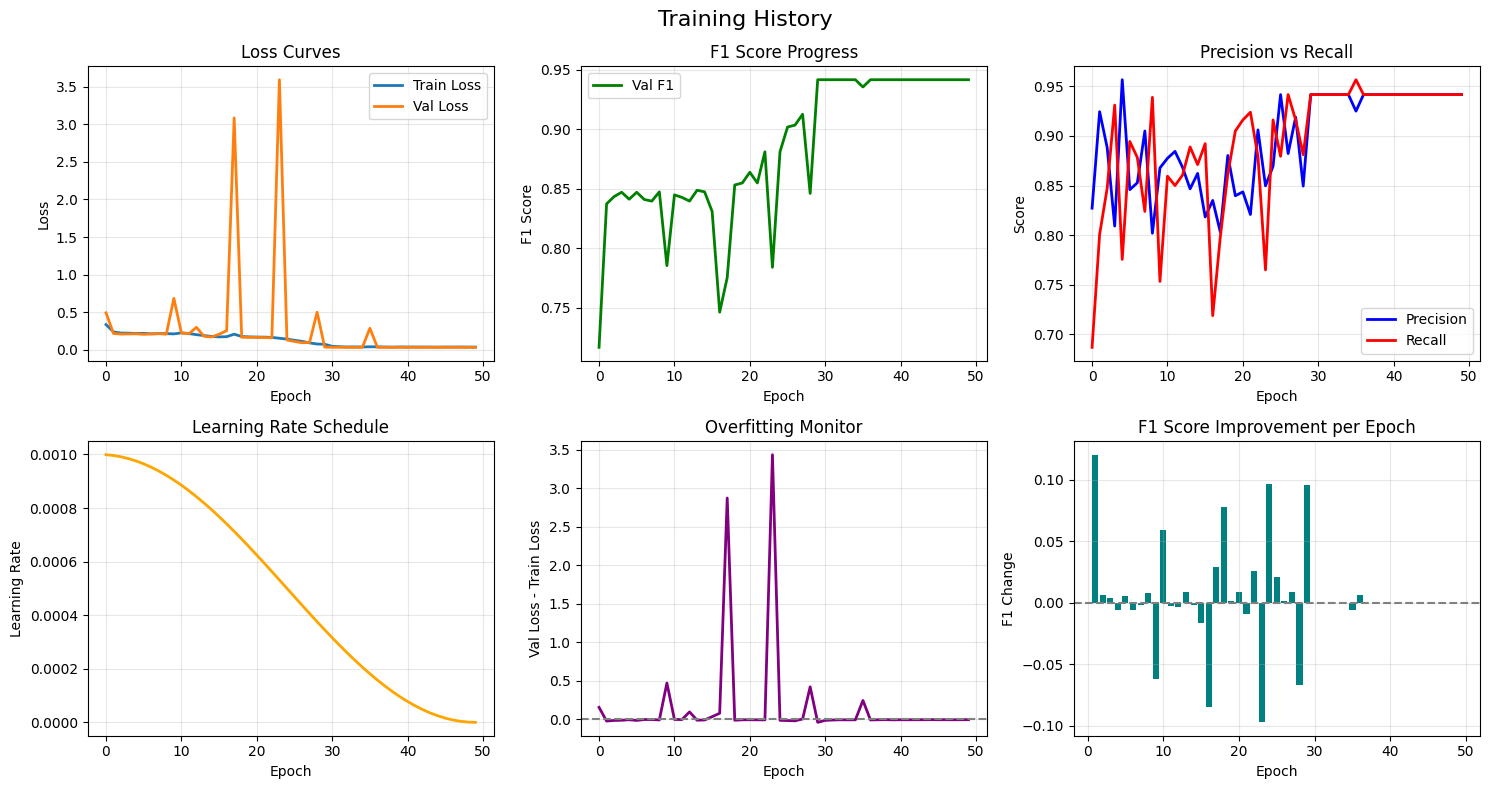

📊 Training plots saved to 'optimized_training_history.png'

🎊 TRAINING COMPLETE - FINAL SUMMARY
Final Test F1 Score: 0.9217
Final Test Hamming Loss: 0.0196
Final Test Exact Match: 92.17%

✨ Model and results saved successfully!


In [7]:
### CELL 8: Run Everything ###

if __name__ == "__main__":
    # Configuration for better performance
    config = {
        'num_classes': 4,
        'batch_size': 128 if device.type == 'cuda' else 32,  # Larger batch for GPU
        'learning_rate': 0.001,
        'num_epochs': 50,  # More epochs for better learning
        'weight_decay': 1e-4,
        'scheduler': 'cosine',
        'dropout': 0.3,
        'num_samples': 3000  # More training data
    }

    # Train the model
    model, history, test_metrics, test_loader = train_model(config)  # Updated to receive test_loader

    # Print final summary
    print("\n" + "="*50)
    print("🎊 TRAINING COMPLETE - FINAL SUMMARY")
    print("="*50)
    print(f"Final Test F1 Score: {test_metrics['f1_score']:.4f}")
    print(f"Final Test Hamming Loss: {test_metrics['hamming_loss']:.4f}")
    print(f"Final Test Exact Match: {test_metrics['exact_match']:.2%}")
    print("\n✨ Model and results saved successfully!")

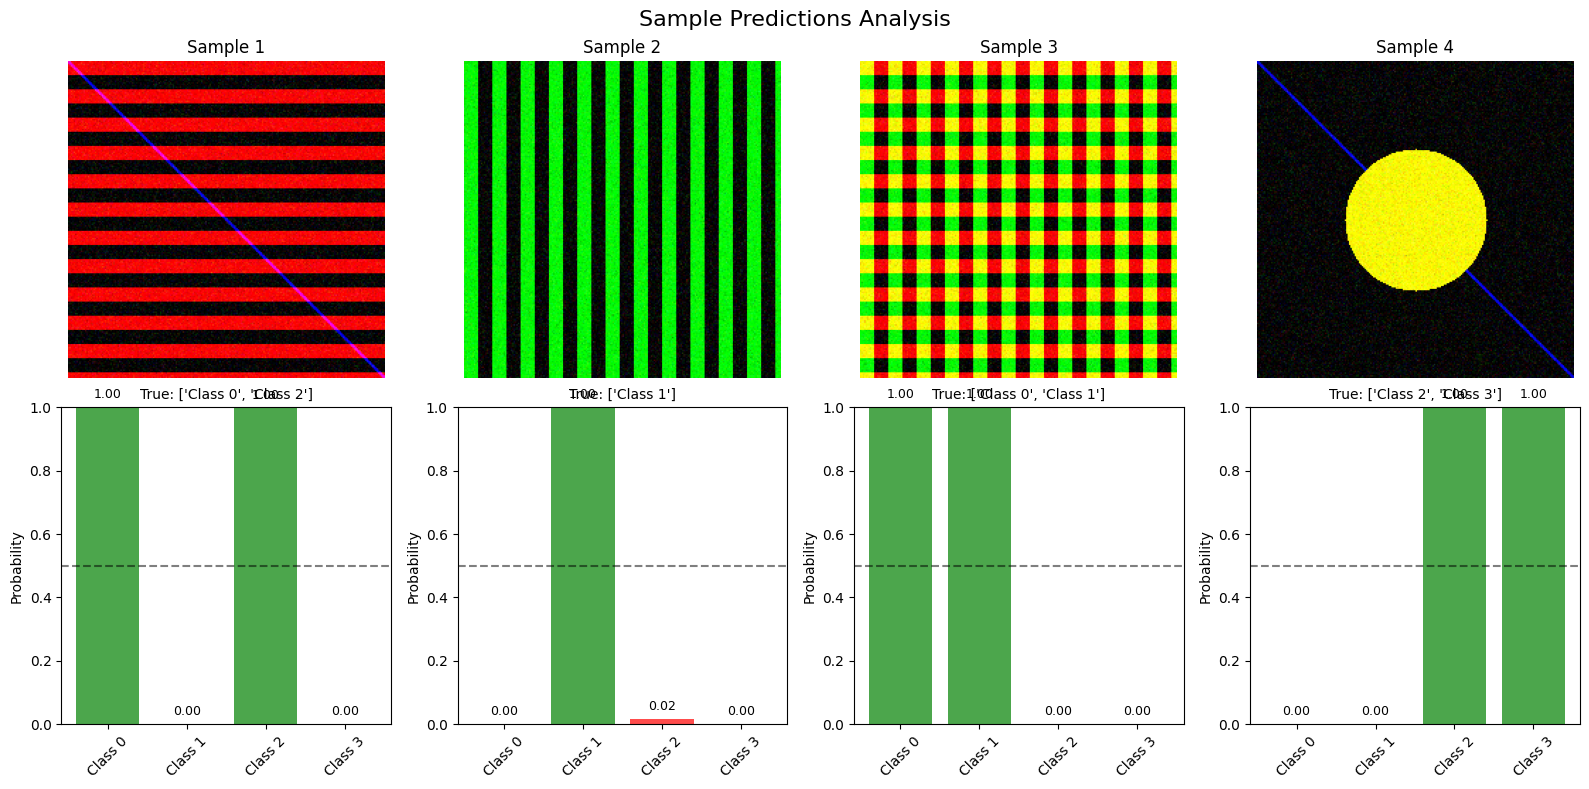

🔍 Prediction analysis saved to 'prediction_analysis.png'


In [8]:
def analyze_model_predictions(model, dataloader, class_names=['Class 0', 'Class 1', 'Class 2', 'Class 3']):
    """Analyze model predictions in detail"""
    model.eval()

    # Get a batch for analysis
    images, labels = next(iter(dataloader))
    images = images[:4].to(device)  # Take first 4 samples
    labels = labels[:4]

    with torch.no_grad():
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu()

    # Create visualization
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Sample Predictions Analysis', fontsize=16)

    for i in range(4):
        # Show image
        img = images[i].cpu()
        # Denormalize
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)

        axes[0, i].imshow(img.permute(1, 2, 0))
        axes[0, i].set_title(f'Sample {i+1}')
        axes[0, i].axis('off')

        # Show predictions
        x = np.arange(len(class_names))
        colors = ['green' if probs[i, j] > 0.5 else 'red' for j in range(len(class_names))]
        bars = axes[1, i].bar(x, probs[i], color=colors, alpha=0.7)
        axes[1, i].set_ylim([0, 1])
        axes[1, i].set_xticks(x)
        axes[1, i].set_xticklabels(class_names, rotation=45)
        axes[1, i].set_ylabel('Probability')
        axes[1, i].axhline(y=0.5, color='black', linestyle='--', alpha=0.5)

        # Add true labels
        true_indices = torch.where(labels[i] == 1)[0]
        title = f"True: {[class_names[idx] for idx in true_indices]}"
        axes[1, i].set_title(title, fontsize=10)

        # Add probability values on bars
        for bar, prob in zip(bars, probs[i]):
            height = bar.get_height()
            axes[1, i].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                          f'{prob:.2f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig('prediction_analysis.png', dpi=100, bbox_inches='tight')
    plt.show()
    print("🔍 Prediction analysis saved to 'prediction_analysis.png'")

# Create a test dataloader for analysis (if not already created)
# This recreates the test_loader that was created inside train_model()
if 'test_loader' not in globals():
    print("Creating test dataloader for analysis...")
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_dataset = OptimizedMultiLabelDataset(
        num_samples=400,  # Small test set
        num_classes=4,
        mode='test',
        transform=test_transform
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False
    )
    print(f"✅ Test dataloader created with {len(test_dataset)} samples")

# Now run the analysis
if 'model' in globals():
    analyze_model_predictions(model, test_loader)
else:
    print("⚠️ Please run the training cell (Cell 8) first to train the model!")